## Лабороторная работа 2. Ассоциативные правила
### Цель работы

Исследование методов анализа ассоциативных правил.  
### Задачи

Загрузить датасет из репозитория (например, kaggle.com или аналогичных платформ). Данные должны представлять собой информацию о купленных вместе товарах .

Привести описание данных из датасета: график вывода длин транзакций, список уникальных товаров и др.

Алгоритм Apriori: выполнить анализ ассоциативных правил при помощи алгоритма Apriori с изначальными условиями в соответствии с вариантом задания. Проанализировать полученные результаты, выделив полезные и тривиальные правила, и оценив значение достоверности, лифта правил. Провести оценку влияния параметров алгоритма на получаемые правила (на количество правил и метрики).

Алгоритм FPG: провести анализ правил, используя алгоритм FPG. В отчете привести правила, получившиеся в результате использования данного алгоритма.

Алгоритмически определить минимальные значения поддержки для составления правил из 1, 2, и т.д. объектов в одном из алгоритмов.

Последовательно меняя параметры (значения поддержки и достоверности) одного из алгоритмов получить наборы ассоциативных правил. Сделать выводы на основе проведенных экспериментов.

Проанализировать получающийся в результате работы программы граф. Объяснить, какую информацию можно из него извлечь.

Предложить и реализовать свой способ визуализации ассоциативных правил и метрик.


### 1) Загрузка данных
Ожидается файл 'groceries - groceries.csv' в рабочем каталоге. Если файл имеет другой формат (один столбец с товарами через запятую), потребуется небольшая корректировка.

In [50]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)
all_data = pd.read_csv('groceries - groceries.csv')
print(all_data)

      Item(s)               Item 1               Item 2            Item 3  \
0           4         citrus fruit  semi-finished bread         margarine   
1           3       tropical fruit               yogurt            coffee   
2           1           whole milk                  NaN               NaN   
3           4            pip fruit               yogurt      cream cheese   
4           4     other vegetables           whole milk    condensed milk   
...       ...                  ...                  ...               ...   
9830       17              sausage              chicken              beef   
9831        1    cooking chocolate                  NaN               NaN   
9832       10              chicken         citrus fruit  other vegetables   
9833        4  semi-finished bread        bottled water              soda   
9834        5              chicken       tropical fruit  other vegetables   

                        Item 4         Item 5          Item 6  \
0         

# Анализ длин транзакций

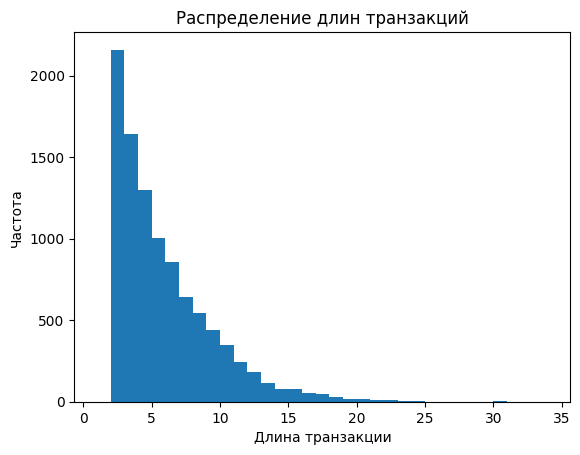

In [51]:
transaction_lengths = all_data.notnull().sum(axis=1)

plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2))
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.show()



По графику видно, что в среднем в одной корзине от трех до 10 товаров. Чаще всего 3 товара.

# Очистка данных

In [52]:
np_data = all_data.to_numpy()
np_data = [[elem for elem in row[1:] if isinstance(elem, str)] for row in np_data]

unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)

print("Количество уникальных товаров:", len(unique_items))
print(unique_items)


Количество уникальных товаров: 169
{'specialty chocolate', 'flour', 'whisky', 'flower soil/fertilizer', 'grapes', 'kitchen towels', 'whole milk', 'detergent', 'domestic eggs', 'female sanitary products', 'sauces', 'vinegar', 'beef', 'baby cosmetics', 'pip fruit', 'butter', 'pet care', 'frozen fruits', 'pork', 'frozen potato products', 'pasta', 'red/blush wine', 'frankfurter', 'sound storage medium', 'hamburger meat', 'misc. beverages', 'curd', 'pastry', 'curd cheese', 'ketchup', 'salty snack', 'mustard', 'pickled vegetables', 'canned beer', 'make up remover', 'margarine', 'beverages', 'soda', 'cream cheese', 'specialty vegetables', 'cat food', 'dishes', 'kitchen utensil', 'dessert', 'frozen dessert', 'seasonal products', 'syrup', 'spices', 'packaged fruit/vegetables', 'chewing gum', 'turkey', 'nuts/prunes', 'potted plants', 'hygiene articles', 'napkins', 'rubbing alcohol', 'roll products', 'light bulbs', 'organic sausage', 'spread cheese', 'fish', 'yogurt', 'chicken', 'liver loaf', 'ot

# Алгоритм FPG
Как работает FPG:  
Шаг 0: Подготовка
- Собрать транзакции (список списков).
- Выбрать min_support (порог поддержки).
- Посчитать частоту каждого товара (support на уровне одиночных элементов).
- Отбросить все элементы, чья поддержка < min_support.
- Отсортиртировать оставшиеся элементы в каждой транзакции по убыванию их глобальной частоты.

Шаг 1: Построение FP-дерева

- Создаётся корневой узел (пустой).

- Каждая транзакция вставляется в дерево как путь: проход по уже существующим веткам увеличивает счётчики узлов; если ветви нет - создаётся новая ветвь.

- После вставки всех транзакций дерево компактно представляет все транзакции: общие префиксы склеены, уникальные части - разветвлены.

Шаг 2: Извлечение частых наборов

Для каждого товара (обычно обрабатывается от наименее частого к наиболее частому, чтобы облегчить рекурсию):

- Собираем conditional pattern base - набор путей (префиксов) в дереве, которые предшествуют узлам с этим товаром, с их счётчиками. Это — все контексты, в которых товар встречается.

- Из conditional pattern base строим условное FP-дерево (conditional FP-tree), аналогично основному, но только из префиксов.

- Рекурсивно запускаем FP-Growth на условном дереве, чтобы получить все частые наборы, включающие рассматриваемый товар. К каждому найденному набору добавляем текущий товар (то есть накапливаем комбинации).

- Если условный FP-tree пуст или состоит из единственной пути, извлекаем частые наборы прямо.

=== Частые наборы ===
    support          itemsets
0  0.082766    (citrus fruit)
1  0.058566       (margarine)
2  0.139502          (yogurt)
3  0.104931  (tropical fruit)
4  0.058058          (coffee)

=== Все правила в читаемом виде ===
11) [root vegetables] → [other vegetables] | support=0.047, confidence=0.435, lift=2.247
13) [sausage] → [rolls/buns] | support=0.031, confidence=0.326, lift=1.771
4) [tropical fruit] → [other vegetables] | support=0.036, confidence=0.342, lift=1.768
14) [whipped/sour cream] → [whole milk] | support=0.032, confidence=0.450, lift=1.760
12) [root vegetables] → [whole milk] | support=0.049, confidence=0.449, lift=1.756
3) [yogurt] → [other vegetables] | support=0.043, confidence=0.311, lift=1.608
5) [tropical fruit] → [whole milk] | support=0.042, confidence=0.403, lift=1.578
2) [yogurt] → [whole milk] | support=0.056, confidence=0.402, lift=1.572
6) [pip fruit] → [whole milk] | support=0.030, confidence=0.398, lift=1.557
7) [other vegetables] → [whole m

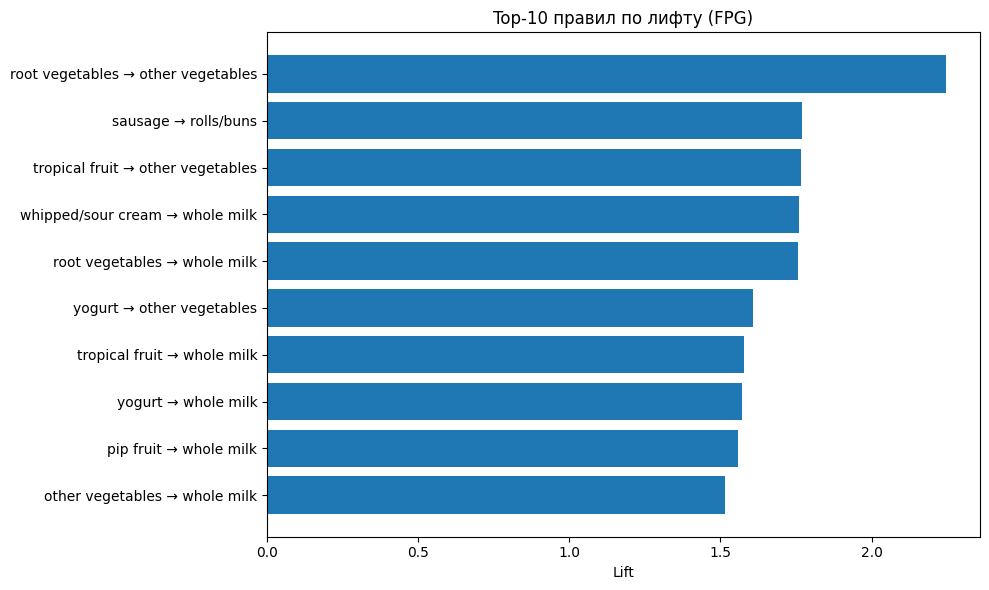

In [53]:
te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)

df_fpg = fpgrowth(data, min_support=0.03, use_colnames=True)
print("=== Частые наборы ===")
print(df_fpg.head())

rules_fpg = association_rules(df_fpg, metric="confidence", min_threshold=0.3)

rules_fpg["antecedent_len"] = rules_fpg["antecedents"].apply(lambda x: len(x))
rules_fpg["consequent_len"] = rules_fpg["consequents"].apply(lambda x: len(x))

rules_fpg_sorted = rules_fpg.sort_values(by="lift", ascending=False)
print("\n=== Все правила в читаемом виде ===")
for idx, row in rules_fpg_sorted.iterrows():
    antecedents = ", ".join(list(row["antecedents"]))
    consequents = ", ".join(list(row["consequents"]))
    print(f"{idx+1}) [{antecedents}] → [{consequents}] | "
          f"support={row['support']:.3f}, confidence={row['confidence']:.3f}, lift={row['lift']:.3f}")

top10 = rules_fpg.sort_values("lift", ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top10)), top10["lift"])
plt.yticks(range(len(top10)), [
    f"{', '.join(list(a))} → {', '.join(list(c))}"
    for a, c in zip(top10["antecedents"], top10["consequents"])
])
plt.xlabel("Lift")
plt.title("Top-10 правил по лифту (FPG)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Вывод по FPG

Зададим начальные значения support = 0.3 и confidence  = 0.3. Получим 14 правил. Отсортируем их по lift. Правило с наибольшим lift (2.25) : [root vegetables] → [other vegetables]. Но оно тривиально, и так понятно что при покупке корнеплодов купят и другие овощи. Можно выделить несколько правил, которые не являются тривиальными:

[sausage] → [rolls/buns]
- support = 3.1%
- confidence = 32.6%
- lift = 1.771
Почему интересно:
Логичный, но статистически значимый паттерн: колбаса покупается вместе с булочками.

Другие правила с высоким лифтом:  
[tropical fruit] → [other vegetables]  
lift = 1.768

[whipped/sour cream] → [whole milk]  
lift = 1.760

[root vegetables] → [whole milk]  
lift = 1.756

Правила у которых lift < 1.5 можно отнести к тривиальным, они не дают никакой новой информации.



## Алгоритм Apriori

=== Частые наборы ===
    support         itemsets
0  0.033452       (UHT-milk)
1  0.052466           (beef)
2  0.033249        (berries)
3  0.080529   (bottled beer)
4  0.110524  (bottled water)

=== Все правила в читаемом виде ===
3) [root vegetables] → [other vegetables] | support=0.047, confidence=0.435, lift=2.247
9) [sausage] → [rolls/buns] | support=0.031, confidence=0.326, lift=1.771
4) [tropical fruit] → [other vegetables] | support=0.036, confidence=0.342, lift=1.768
13) [whipped/sour cream] → [whole milk] | support=0.032, confidence=0.450, lift=1.760
11) [root vegetables] → [whole milk] | support=0.049, confidence=0.449, lift=1.756
6) [yogurt] → [other vegetables] | support=0.043, confidence=0.311, lift=1.608
12) [tropical fruit] → [whole milk] | support=0.042, confidence=0.403, lift=1.578
14) [yogurt] → [whole milk] | support=0.056, confidence=0.402, lift=1.572
8) [pip fruit] → [whole milk] | support=0.030, confidence=0.398, lift=1.557
5) [other vegetables] → [whole milk] |

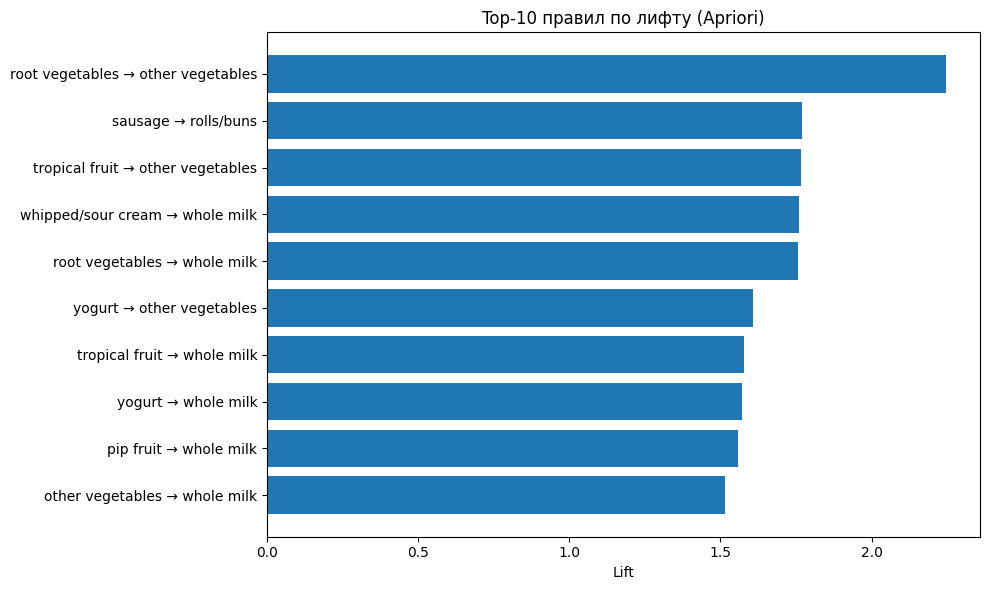

In [54]:
te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)

df_ap = apriori(data, min_support=0.03, use_colnames=True)
print("=== Частые наборы ===")
print(df_ap.head())

rules_ap = association_rules(df_ap, metric="confidence", min_threshold=0.3)

rules_ap["antecedent_len"] = rules_ap["antecedents"].apply(lambda x: len(x))
rules_ap["consequent_len"] = rules_ap["consequents"].apply(lambda x: len(x))

rules_ap_sorted = rules_ap.sort_values(by="lift", ascending=False)
print("\n=== Все правила в читаемом виде ===")
for idx, row in rules_ap_sorted.iterrows():
    antecedents = ", ".join(list(row["antecedents"]))
    consequents = ", ".join(list(row["consequents"]))
    print(f"{idx+1}) [{antecedents}] → [{consequents}] | "
          f"support={row['support']:.3f}, confidence={row['confidence']:.3f}, lift={row['lift']:.3f}")

top10 = rules_ap_sorted.head(10)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top10)), top10["lift"])
plt.yticks(range(len(top10)), [
    f"{', '.join(list(a))} → {', '.join(list(c))}"
    for a, c in zip(top10["antecedents"], top10["consequents"])
])
plt.xlabel("Lift")
plt.title("Top-10 правил по лифту (Apriori)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Результаты получились аналогичны алгоритму FPG. При заданной support и confidence правил получилось столько же.

Также можно отметить, что алгоритм работает намного медленне чем FPG

## График достоверности (confidence)

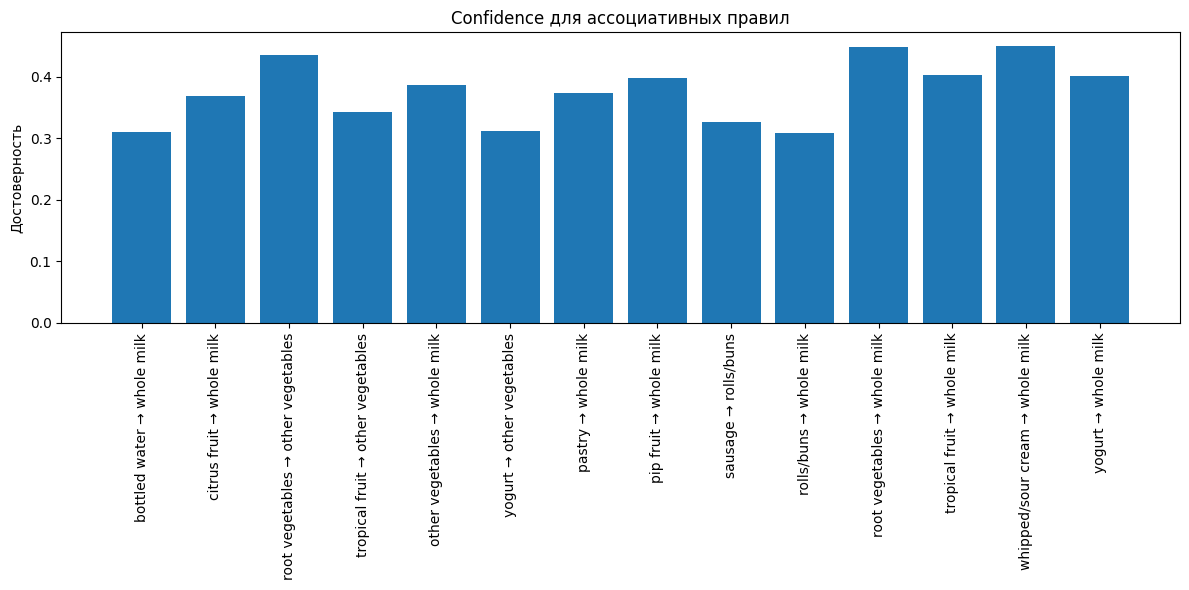

In [55]:
rules_ap['antecedents'] = rules_ap['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_ap['consequents'] = rules_ap['consequents'].apply(lambda x: ', '.join(list(x)))

products_1 = rules_ap["antecedents"].tolist()
products_2 = rules_ap["consequents"].tolist()
confidence = rules_ap["confidence"].tolist()

rules_labels = [f"{a} → {c}" for a, c in zip(products_1, products_2)]

plt.figure(figsize=(12, 6))
plt.bar(rules_labels, confidence)
plt.xticks(rotation=90)
plt.ylabel("Достоверность")
plt.title("Confidence для ассоциативных правил")
plt.tight_layout()
plt.show()

## Визуализация правил в виде графа

/tmp/ipykernel_17046/2643026392.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


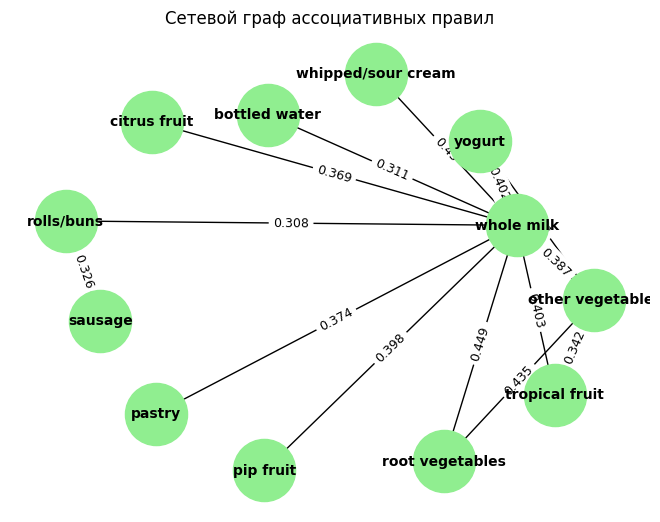

In [56]:


G = nx.Graph()


for index, row in rules_fpg_sorted.iterrows():
    ant = list(row['antecedents'])[0]
    con = list(row['consequents'])[0]
    conf = round(row['confidence'], 3)

    G.add_node(ant)
    G.add_node(con)
    G.add_edge(ant, con, weight=conf)

pos = nx.spring_layout(G, k=2)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightgreen', font_size=10, font_weight='bold')

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title('Сетевой граф ассоциативных правил')
plt.tight_layout()
plt.show()



Граф показывает структуру зависимостей между товарами, у нас:  
вершины - товары  
ребра - правила A -> B  
вес ребра — достоверность правила  

Граф показывает:
- Насколько сильные правила (по расстоянию и подписи)
- Узлы с большим количеством связей — ключевые товары.

Видно например что молоко это ключевой товар, оно находится в центре графа и к нему ведет много связей.

## Минимальная поддержка для наборов 1,2,3 элементов

In [63]:
from mlxtend.frequent_patterns import fpgrowth

min_sup = 0.01
step = 0.05
target_size = 3

found = False
results = []

while min_sup > 0:
    df_temp = fpgrowth(data, min_support=min_sup, use_colnames=True)
    
    df_size3 = df_temp[df_temp['itemsets'].apply(lambda x: len(x) == target_size)]
    
    results.append([min_sup, len(df_size3)])
    
    if len(df_size3) > 0:
        print(f"Найдены частые наборы длины {target_size} при поддержке: {min_sup}")
        display(df_size3.head())
        found = True
        break
    
    min_sup -= step

if not found:
    print(f"наборы длины {target_size} не найдены.")

pd.DataFrame(results, columns=["support", f"count_of_size{target_size}"])

Найдены частые наборы длины 3 при поддержке: 0.01


,support,itemsets
97,0.010269,"(yogurt, whole milk, citrus fruit)"
98,0.013015,"(other vegetables, whole milk, citrus fruit)"
99,0.010371,"(other vegetables, citrus fruit, root vegetables)"
111,0.010473,"(yogurt, soda, whole milk)"
112,0.015557,"(rolls/buns, yogurt, whole milk)"


,support,count_of_size3
0,0.01,32


Видно, что при меняя параметр min_suppport, например сделав его равным 0.01 можно получить наборы длиной три, а при больших min_support получаются наборы меньшей длины.

## Эксперимент: влияние поддержки и достоверности

In [64]:
supports = [0.01, 0.02, 0.03, 0.05]
results = []

for s in supports:
    df_test = apriori(data, min_support=s, use_colnames=True)
    rules_test = association_rules(df_test, metric="confidence", min_threshold=0.4)
    results.append([s, len(df_test), len(rules_test)])

pd.DataFrame(results, columns=["support", "frequent_sets", "rules"])

,support,frequent_sets,rules
0,0.01,333,62
1,0.02,122,15
2,0.03,63,5
3,0.05,31,1


Вывод

- Чем ниже поддержка, тем больше наборов генерирует алгоритм.

- Но слишком низкая поддержка делает правила менее полезными.

## Собственная визуализация правил (тепловая карта)
Построим тепловую карту , показывающую значение лифта для всех правил Apriori.Строки - товары левой части правила столбцы - товары из правой части. Ячейка содержит значение лифта этого правила. Там, где правила нет - NaN. Чем ярче/темнее клетка, тем выше lift. 

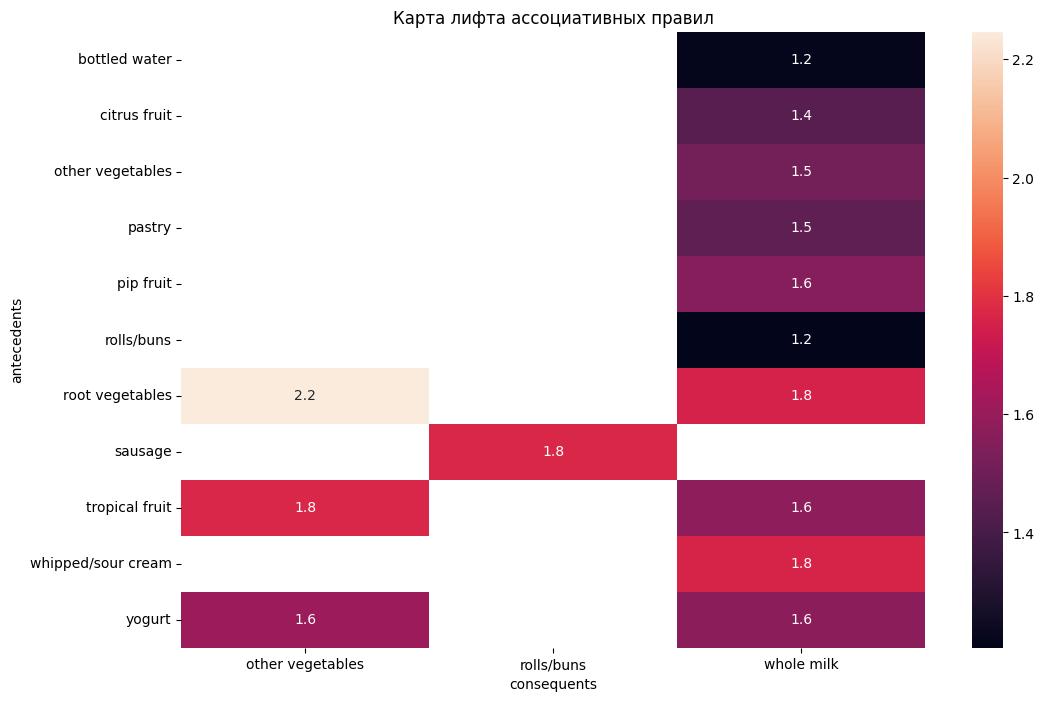

In [65]:
import numpy as np

pivot = rules_ap.pivot_table(values='lift',
                              index='antecedents',
                              columns='consequents')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True);
plt.title("Карта лифта ассоциативных правил")
plt.show()

## Выводы
В ходе лабораторной работы был выполнен анализ набора данных с транзакциями магазина. С помощью алгоритмов FPGrowth и Apriori были сформированы ассоциативные правила, выявляющие закономерности совместной покупки определённых групп товаров, например, «root vegetables» и «whole milk». Также был проведён эксперимент по изменению параметров min_support и min_confidence для алгоритма Apriori. Результаты показали, что при снижении минимального уровня поддержки появляются более длинные последовательности товаров, однако значение lift для них уменьшается, что указывает на меньшую надёжность таких правил. Для наглядного представления полученных закономерностей были выполнены визуализации с использованием сетевого графа и тепловой карты.